In [1]:
import urllib.request
import os

In [2]:
if not os.path.exists('data'):
    os.makedirs('data')
url='https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.xls'
filepath = 'data/tatanic3.xls'
if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url,filepath)
    print('download:',result)


In [3]:
import numpy
import pandas as pd

In [4]:
#pip install xlrd
all_df = pd.read_excel(filepath)

In [5]:
all_df[:2]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"


In [6]:
cols=['survived','name','pclass','sex','age','sibsp','parch','fare','embarked']
all_df = all_df[cols]

In [7]:
all_df[:2]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
0,1,"Allen, Miss. Elisabeth Walton",1,female,29.0000,0,0,211.3375,S
1,1,"Allison, Master. Hudson Trevor",1,male,0.9167,1,2,151.5500,S


In [8]:
df = all_df.drop(['name'],axis=1)

In [9]:
all_df.isnull().sum()

survived      0
name          0
pclass        0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

In [10]:
age_mean = df['age'].mean()
df['age'] = df['age'].fillna(age_mean)

In [11]:
fare_mean = df['fare'].mean()
df['fare'] = df['fare'].fillna(fare_mean)

In [12]:
df['sex']=df['sex'].map({'female':0,'male':1}).astype(int)

In [13]:
x_OneHot_df = pd.get_dummies(data=df,columns=['embarked'])

In [14]:
x_OneHot_df[:2]

,survived,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,1,1,0,29.0000,0,0,211.3375,False,False,True
1,1,1,1,0.9167,1,2,151.5500,False,False,True


In [15]:
ndarray = x_OneHot_df.values

In [16]:
ndarray.shape

(1309, 10)

In [17]:
ndarray[:2]

array([[1, 1, 0, 29.0, 0, 0, 211.3375, False, False, True],
       [1, 1, 1, 0.9167, 1, 2, 151.55, False, False, True]], dtype=object)

In [18]:
Label = ndarray[:,0]
Features = ndarray[:,1:]

In [19]:
Label[:2]

array([1, 1], dtype=object)

In [20]:
Features[:2]

array([[1, 0, 29.0, 0, 0, 211.3375, False, False, True],
       [1, 1, 0.9167, 1, 2, 151.55, False, False, True]], dtype=object)

In [21]:
#pip install scikit-learn
from sklearn import preprocessing

In [22]:
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))

In [23]:
scaledFeatures = minmax_scale.fit_transform(Features)

In [24]:
scaledFeatures[:2]

array([[0.        , 0.        , 0.36116884, 0.        , 0.        ,
        0.41250333, 0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.00939458, 0.125     , 0.22222222,
        0.2958059 , 0.        , 0.        , 1.        ]])

In [25]:
msk = numpy.random.rand(len(all_df)) < 0.8
train_df = all_df[msk]
test_df = all_df[~msk]

In [26]:
print('total:',len(all_df),'train:',len(train_df),'test:',len(test_df))

total: 1309 train: 1046 test: 263


In [27]:
def PreprocessData(raw_df):
    df=raw_df.drop(['name'],axis=1)
    age_mean=df['age'].mean()
    df['age'] = df['age'].fillna(age_mean)
    fare_mean = df['fare'].mean()
    df['fare'] = df['fare'].fillna(fare_mean)
    df['sex']=df['sex'].map({'female':0,'male':1}).astype(int)
    x_OneHot_df = pd.get_dummies(data=df,columns=['embarked'])

    ndarray = x_OneHot_df.values
    Features = ndarray[:,1:]
    Label = ndarray[:,0]

    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))
    scaledFeatures = minmax_scale.fit_transform(Features)

    return scaledFeatures,Label

In [28]:
train_Features,train_Label = PreprocessData(train_df)
test_Features,test_Label = PreprocessData(test_df)

In [29]:
train_Features[:2]

array([[0.        , 0.        , 0.36116884, 0.        , 0.        ,
        0.41250333, 0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.00939458, 0.125     , 0.22222222,
        0.2958059 , 0.        , 0.        , 1.        ]])

In [30]:
train_Label[:2]

array([1, 1], dtype=object)

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [33]:
model = Sequential()

In [34]:
model.add(Dense(units=40, input_dim=9, kernel_initializer='uniform', activation='relu'))

In [35]:
model.add(Dense(units=30, kernel_initializer='uniform', activation='relu'))

In [36]:
model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

In [37]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
x = numpy.asarray(train_Features).astype('float32')
y = numpy.asarray(train_Label).astype('float32')
train_history = model.fit(x=x, y=y, validation_split=0.1, epochs=30, batch_size=30, verbose=2)

Epoch 1/30
32/32 - 0s - loss: 0.6902 - accuracy: 0.5972 - val_loss: 0.6742 - val_accuracy: 0.7714 - 166ms/epoch - 5ms/step
Epoch 2/30
32/32 - 0s - loss: 0.6686 - accuracy: 0.6015 - val_loss: 0.6031 - val_accuracy: 0.7714 - 15ms/epoch - 479us/step
Epoch 3/30
32/32 - 0s - loss: 0.6155 - accuracy: 0.6451 - val_loss: 0.5082 - val_accuracy: 0.7714 - 15ms/epoch - 459us/step
Epoch 4/30
32/32 - 0s - loss: 0.5551 - accuracy: 0.7333 - val_loss: 0.4751 - val_accuracy: 0.7714 - 16ms/epoch - 506us/step
Epoch 5/30
32/32 - 0s - loss: 0.5124 - accuracy: 0.7694 - val_loss: 0.4497 - val_accuracy: 0.7714 - 15ms/epoch - 478us/step
Epoch 6/30
32/32 - 0s - loss: 0.4971 - accuracy: 0.7758 - val_loss: 0.4503 - val_accuracy: 0.7905 - 15ms/epoch - 480us/step
Epoch 7/30
32/32 - 0s - loss: 0.4868 - accuracy: 0.7768 - val_loss: 0.4538 - val_accuracy: 0.7905 - 16ms/epoch - 498us/step
Epoch 8/30
32/32 - 0s - loss: 0.4818 - accuracy: 0.7790 - val_loss: 0.4483 - val_accuracy: 0.8000 - 16ms/epoch - 486us/step
Epoch 9/3

In [39]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

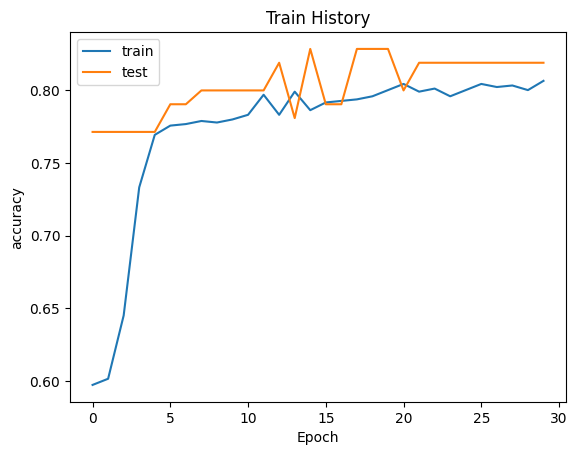

In [40]:
show_train_history(train_history, 'accuracy', 'val_accuracy')

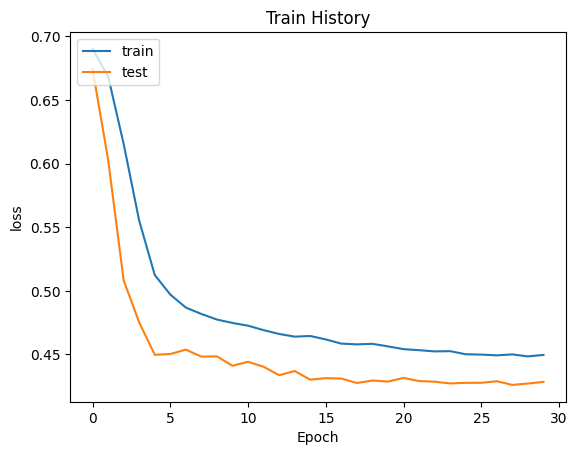

In [41]:
show_train_history(train_history, 'loss', 'val_loss')

In [42]:
x = numpy.asarray(test_Features).astype('float32')
y = numpy.asarray(test_Label).astype('float32')
scores = model.evaluate(x=x, y=y)

9/9 [==============================] - 0s 602us/step - loss: 0.4438 - accuracy: 0.7871


In [43]:
scores[1]

0.7870722413063049

In [44]:
Jack = pd.Series([0, 'Jack', 3, 'male', 23, 1, 0, 5.0000, 'S'])
Rose = pd.Series([1, 'Rose', 1, 'female', 20, 1, 0, 100.0000, 'S'])

In [45]:
JR_df = pd.DataFrame([list(Jack), list(Rose)],
                     columns=cols)

In [46]:
all_df=pd.concat([all_df, JR_df])

In [47]:
all_df[-2:]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
0,0,Jack,3,male,23.0,1,0,5.0,S
1,1,Rose,1,female,20.0,1,0,100.0,S


In [48]:
all_Features, Label=PreprocessData(all_df)

In [49]:
all_probability=model.predict(all_Features)

41/41 [==============================] - 0s 209us/step


In [50]:
all_probability[:10]

array([[0.96923274],
       [0.6703931 ],
       [0.9739244 ],
       [0.42174804],
       [0.96611094],
       [0.25117174],
       [0.9016142 ],
       [0.3111951 ],
       [0.9008757 ],
       [0.19721341]], dtype=float32)

In [51]:
pd=all_df
pd.insert(len(all_df.columns), 'probability', all_probability)

In [52]:
pd[-2:]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
0,0,Jack,3,male,23.0,1,0,5.0,S,0.132017
1,1,Rose,1,female,20.0,1,0,100.0,S,0.963343


In [53]:
pd[(pd['survived'] == 0) & (pd['probability'] > 0.9)]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
2,0,"Allison, Miss. Helen Loraine",1,female,2.0,1,2,151.5500,S,0.973924
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,female,25.0,1,2,151.5500,S,0.966111
105,0,"Evans, Miss. Edith Corse",1,female,36.0,0,0,31.6792,C,0.971048
169,0,"Isham, Miss. Ann Elizabeth",1,female,50.0,0,0,28.7125,C,0.965805
286,0,"Straus, Mrs. Isidor (Rosalie Ida Blun)",1,female,63.0,1,0,221.7792,S,0.919451


In [54]:
pd[:5]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
0,1,"Allen, Miss. Elisabeth Walton",1,female,29.0000,0,0,211.3375,S,0.969233
1,1,"Allison, Master. Hudson Trevor",1,male,0.9167,1,2,151.5500,S,0.670393
2,0,"Allison, Miss. Helen Loraine",1,female,2.0000,1,2,151.5500,S,0.973924
3,0,"Allison, Mr. Hudson Joshua Creighton",1,male,30.0000,1,2,151.5500,S,0.421748
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,female,25.0000,1,2,151.5500,S,0.966111
